In [1]:
import json
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import sys
import itertools
import scipy.stats as stats

In [2]:
def load_results(model_type):
    file_name = '../output/'+model_type+"/sessions_dict"
    #file_name = '/media/martijn/Data/Data/Models/output/'+model_type+"/results_dict"
    print file_name
    with open(file_name, 'rb') as f:
        results = json.load(f)
    return results


In [3]:
def add_no_clicks(seq):
        num_seq = 4
        seq_len = 10
        num_perms = seq.shape[0]
        zeros = np.zeros((4,1))
        for i in xrange(num_seq-int(np.sum(seq[0]))):
            zeros[num_seq-(1+i)] = 1
        z = np.expand_dims(zeros,axis=0)
        z = np.repeat(z, seq.shape[0], 0)
        seq = np.concatenate((seq,z),2)
        return seq
    
def non_sequential_sequences(n):
        z11 = np.zeros(10)
        one_hot_vectors = np.asarray(np.eye(n))
        no_click = np.expand_dims(np.repeat(np.expand_dims(z11,0),4,0),0)
        no_click = add_no_clicks(no_click)

        one_click = []
        for oh in one_hot_vectors:
            seq = [oh,z11,z11,z11]
            one_click.append(seq)
        one_click = np.asarray(one_click)
        one_click = add_no_clicks(one_click)

        two_clicks = []
        for oh in one_hot_vectors:
            for oh2 in one_hot_vectors:
                if not np.array_equal(oh,oh2):
                    seq = [oh,oh2,z11,z11]
                    two_clicks.append(seq)
        two_clicks = np.asarray(two_clicks)
        two_clicks = add_no_clicks(two_clicks)

        three_clicks = []
        for oh1 in one_hot_vectors:
            for oh2 in one_hot_vectors:
                for oh3 in one_hot_vectors:
                    if not np.array_equal(oh1,oh2) and not np.array_equal(oh1,oh3) and not np.array_equal(oh2,oh3):
                        seq = [oh1, oh2, oh3, z11]
                        three_clicks.append(seq)
        three_clicks = np.asarray(three_clicks)
        three_clicks = add_no_clicks(three_clicks)
        sequences = np.concatenate((no_click, one_click,two_clicks,three_clicks),axis=0)
        return sequences

def add_empty(nonseq):
    empty = np.zeros((821,6,11))
    empty[:,:,-1] = 1
    nonseq = np.concatenate((nonseq, empty),axis=1)
    return nonseq
    
def sequential_sequences(k):
        temp_seq = [''.join(x) for x in itertools.product('01', repeat=k)]
        sequences = []
        for seq in temp_seq:
            sequences.append(np.split(np.asarray(list(seq)),k))
        sequences = np.asarray(sequences).astype(float)
        return sequences




In [4]:
def get_best(scores, n):
    best = sorted(scores.items(), key=itemgetter(1),reverse=True)
    return best[0:n]

def get_bins(sequences, sessions, n):
    i = 0
    bins = np.zeros((11,1))
    for key in sessions:
        i += 1
        best = get_best(sessions[key]['predictions'], n)
        for j in range(0,n):
            if sequences[int(best[j][0][0:10])].shape[1] < 11:
                bins[int(np.sum(sequences[int(best[j][0][0:10])]))] += 1
            else:
                bins[int(np.sum(sequences[int(best[j][0])][:,:10]))] += 1
    return bins


In [5]:

def process_dict(model, f):
    sessions = load_results(f)
    if model == 'seq':
        sequences = sequential_sequences(10)
    else:
        sequences = non_sequential_sequences(10)
        sequences_complete = add_empty(sequences)
    bins1 = get_bins(sequences, sessions,1)
    bins5 = get_bins(sequences, sessions,5)
    bins10 = get_bins(sequences, sessions,10)
    return bins1, bins5, bins10

# bins_seq_1, bins_seq_5, bins_seq_10 = process_dict('seq', "TEST/sequential")
# bins_nonseq_1, bins_nonseq_5, bins_nonseq_10 = process_dict('nonseq', "TEST/non_sequential")
# bins_attention_1, bins_attention_5, bins_attention_10 = process_dict('attention', "TEST/attention")

def process_labels(f):
    sessions = load_results(f)
    bins = np.zeros((11,1))
    for key in sessions:
        l = sessions[key]['label']
        #print l
        length = np.sum(l)
        bins[int(length)] += 1
    return bins    
    
# bins_labels = process_labels('TEST/sequential')
# print bins_labels
        

In [6]:
save_destination = "../plots/"
def make_bars(bins_prediction, bins_label, model, n):
    bins_prediction = bins_prediction/np.sum(bins_prediction)
    bins_label = bins_label/np.sum(bins_label)  

    begin = 0
    end = 10
    fig = plt.figure()
    plt.title(model + ': lengths with ' + str(n) + ' predictio(s)')
    width = 0.45
    plt.bar(np.arange(begin,end),bins_label[begin:end],  width, color='b', label='Label')
    plt.bar(np.arange(begin,end)+width,bins_prediction[begin:end],  width, color='r',label='Prediction')
    plt.xticks(np.arange(begin,end))
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),
              ncol=1, fancybox=True, shadow=True)
    #plt.savefig(save_destination+"lengths_"+model+"_"+str(n), format='pdf', dpi=1200)
    plt.show()
    return bins_label, bins_prediction

# print bins_seq_10
# print bins_nonseq_10
# print bins_attention_10
# print bins_labels
    
# label, bs1 = make_bars(bins_seq_1, bins_labels, 'sequential', 1)
# label, bns1 = make_bars(bins_nonseq_1, bins_labels, 'nonsequential', 1)
# label, ba1 = make_bars(bins_attention_1, bins_labels, 'attention', 1)
# label, bs5 = make_bars(bins_seq_5, bins_labels, 'sequential', 5)
# label, bns5 = make_bars(bins_nonseq_5, bins_labels, 'nonsequential', 5)
# label, ba5 = make_bars(bins_attention_5, bins_labels, 'attention', 5)
# label, bs10 = make_bars(bins_seq_10, bins_labels, 'sequential', 10)
# label, bns10 = make_bars(bins_nonseq_10, bins_labels, 'nonsequential', 10)
# label, ba10 = make_bars(bins_attention_10, bins_labels, 'attention', 10)

# print label
# print bs1
# print bns1
# print ba1
# print bs5
# print bns5
# print ba5
# print bs10
# print bns10
# print ba10


In [7]:
# Creates ordered clicks from 10x11 click sequence
def preprocess( clicks):
    if len(np.where(clicks==1.0)) > 1:
        clicks = np.where(clicks == 1.0)[1] + 1
        clicks = clicks[clicks<11].tolist()
    else:
        clicks = []
    return clicks

    # Creates ordered clicks from 1x10 click sequence (for sequential prediction)
def preprocess2(clicks):
    clicks = np.where(clicks == 1.0)[0] + 1
    clicks = clicks.tolist()
    return clicks

def ordered_seq2set(clicks):
    if len(clicks.shape) == 1: # Sequential
        return preprocess2(np.transpose(clicks))
    else:
        return preprocess(clicks)

In [8]:
def reciprocal_rank(best_predictions, labels):
        rr = 1.0/(len(labels)+1)
        validation_labels = ordered_seq2set(np.asarray(labels))
        for j in range(0,len(best_predictions)):
            clicks = ordered_seq2set(best_predictions[j])
            if np.array_equal(validation_labels, clicks):
                rr = 1.0/(j+1)
                break
        return rr


    
def recall_at_r(recip_rank):
    recall = np.zeros((1,4))
    for i in range(0,1):
        rr = recip_rank
        if rr == 1.0:
            recall[i,:] = 1.0
        elif rr >= (1.0/3):
            recall[i,1:] = 1.0
        elif rr >= 0.2:
            recall[i,2:] = 1.0
        elif rr >= 0.1:
            recall[i,3] = 1.0
    return recall

def mean_recall_at(f, model):
    i = 0
    sessions = load_results(f)
    recall_at = np.zeros(((1,4)))
    rr = 0.0
    for key in sessions:
        i+=1
#         if i > 100:
#             break
        if model == 'seq':
            sequences = sequential_sequences(10)
        else:
            sequences = non_sequential_sequences(10)
        best_predictions = get_best(sessions[key]['predictions'],10)
        predictions = []
        for bp in best_predictions:
            predictions.append(sequences[int(bp[0])])
        recip_rank = reciprocal_rank(predictions,sessions[key]['full_label'])
        rr += recip_rank
        recall = recall_at_r(recip_rank)
        recall_at += recall
    return np.round(recall_at/i, 3), np.round(rr/i, 3)
        
# recall, rr = mean_recall_at('TEST/sequential', 'seq')
# print recall
# print rr
# recall, rr = mean_recall_at('TEST/non_sequential', 'nonseq')
# print recall
# print rr
# recall, rr = mean_recall_at('TEST/attention', 'nonseq')
# print recall
# print rr

../output/TEST/sequential/sessions_dict
[[ 0.465  0.619  0.62   0.62 ]]
0.576

../output/TEST/non_sequential/sessions_dict
[[ 0.464  0.677  0.733  0.794]]
0.601

../output/TEST/attention/sessions_dict
[[ 0.468  0.678  0.734  0.794]]
0.604

In [9]:
sequence = [[0,1,0,0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0]]

print ordered_seq2set(np.asarray(sequence))

[2, 1]


In [10]:
x = [1]*10
print x

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [11]:
def is_sequential(sequence):
    for i in range(1, len(sequence)):
        if sequence[i] < sequence[i-1]:
            return False
    return True

def reciprocal_rank(best_predictions, labels):
        rr = 1.0/(len(labels)+1)
        validation_labels = ordered_seq2set(np.asarray(labels))
        for j in range(0,len(best_predictions)):
            clicks = ordered_seq2set(best_predictions[j])
            if np.array_equal(validation_labels, clicks):
                rr = 1.0/(j+1)
                break
        return rr, validation_labels

def recall_at_r(recip_rank):
    recall = np.zeros((1,4))
    for i in range(0,1):
        rr = recip_rank
        if rr == 1.0:
            recall[i,:] = 1.0
        elif rr >= (1.0/3):
            recall[i,1:] = 1.0
        elif rr >= 0.2:
            recall[i,2:] = 1.0
        elif rr >= 0.1:
            recall[i,3] = 1.0
    return recall

def mean_recall_at(f, model):
    i = 0
    i_seq = 0
    i_nonseq = 0
    i_0 = 0
    i_1 = 0
    sessions = load_results(f)
    recall_at = np.zeros(((1,4)))
    recall_at_0 = np.zeros(((1,4)))
    recall_at_1 = np.zeros(((1,4)))
    recall_at_seq = np.zeros(((1,4)))
    recall_at_nonseq = np.zeros(((1,4)))
    rr = 0.0
    rr_0 = 0.0
    rr_1 = 0.0
    rr_seq = 0.0
    rr_nonseq = 0.0
    for key in sessions:
        i+=1
#         if i > 100:
#             break
        if model == 'seq':
            sequences = sequential_sequences(10)
        else:
            sequences = non_sequential_sequences(10)
        best_predictions = get_best(sessions[key]['predictions'],10)
        predictions = []
        for bp in best_predictions:
            if model == 'seq':
                predictions.append(sequences[int(bp[0])].flatten())
            else:
                predictions.append(sequences[int(bp[0])])
        recip_rank, validation_labels = reciprocal_rank(predictions,sessions[key]['full_label'])
        rr += recip_rank
        recall = recall_at_r(recip_rank)
        if len(validation_labels) == 0:
            i_0 += 1
            rr_0 += recip_rank
            recall_at_0 += recall
        elif len(validation_labels) == 1:
            i_1 += 1
            rr_1 += recip_rank
            recall_at_1 += recall
        elif is_sequential(validation_labels):
            i_seq += 1
            rr_seq += recip_rank
            recall_at_seq += recall
        else:
            i_nonseq += 1
            rr_nonseq += recip_rank
            recall_at_nonseq += recall
        recall_at += recall
    recall = [np.round(recall_at/i, 3), np.round(recall_at_0/i_0, 3), np.round(recall_at_1/i_1, 3), 
                  np.round(recall_at_seq/i_seq, 3), np.round(recall_at_nonseq/i_nonseq, 3)]
    recip = [np.round(rr/i, 3), np.round(rr_0/i_0, 3), np.round(rr_1/i_1, 3), 
                 np.round(rr_seq/i_seq, 3), np.round(rr_nonseq/i_nonseq, 3)]
    return recall, recip
        
recall_seq, rr_seq = mean_recall_at('TEST/sequential', 'seq')
print recall_seq
print rr_seq
recall_nonseq, rr_nonseq = mean_recall_at('TEST/non_sequential', 'nonseq')
print recall_nonseq
print rr_nonseq
recall_att, rr_att = mean_recall_at('TEST/attention', 'nonseq')
print recall_att
print rr_att


../output/TEST/sequential/sessions_dict
[array([[ 0.466,  0.678,  0.736,  0.793]]), array([[ 0.804,  0.998,  1.   ,  1.   ]]), array([[ 0.476,  0.786,  0.868,  0.944]]), array([[ 0.   ,  0.058,  0.179,  0.316]]), array([[ 0.,  0.,  0.,  0.]])]
[0.60299999999999998, 0.90000000000000002, 0.64900000000000002, 0.129, 0.090999999999999998]
../output/TEST/non_sequential/sessions_dict
[array([[ 0.464,  0.677,  0.733,  0.794]]), array([[ 0.76,  1.  ,  1.  ,  1.  ]]), array([[ 0.5  ,  0.793,  0.859,  0.945]]), array([[ 0.   ,  0.024,  0.177,  0.29 ]]), array([[ 0.   ,  0.008,  0.021,  0.064]])]
[0.60099999999999998, 0.879, 0.66100000000000003, 0.122, 0.096000000000000002]
../output/TEST/attention/sessions_dict
[array([[ 0.468,  0.678,  0.734,  0.794]]), array([[ 0.774,  1.   ,  1.   ,  1.   ]]), array([[ 0.501,  0.796,  0.864,  0.944]]), array([[ 0.   ,  0.021,  0.165,  0.295]]), array([[ 0.   ,  0.007,  0.024,  0.063]])]
[0.60399999999999998, 0.88500000000000001, 0.66300000000000003, 0.121, 0.

../output/TEST/sequential/sessions_dict
[array([[ 0.465,  0.619,  0.62 ,  0.62 ]]), array([[ 0.804,  0.998,  1.   ,  1.   ]]), array([[ 0.474,  0.678,  0.678,  0.678]]), array([[ 0.,  0.,  0.,  0.]]), array([[ 0.,  0.,  0.,  0.]])]
[0.57599999999999996, 0.90000000000000002, 0.60499999999999998, 0.090999999999999998, 0.090999999999999998]

../output/TEST/non_sequential/sessions_dict
[array([[ 0.464,  0.677,  0.733,  0.794]]), array([[ 0.76,  1.  ,  1.  ,  1.  ]]), array([[ 0.5  ,  0.793,  0.859,  0.945]]), array([[ 0.   ,  0.024,  0.177,  0.29 ]]), array([[ 0.   ,  0.008,  0.021,  0.064]])]
[0.60099999999999998, 0.879, 0.66100000000000003, 0.122, 0.096000000000000002]

../output/TEST/attention/sessions_dict
[array([[ 0.468,  0.678,  0.734,  0.794]]), array([[ 0.774,  1.   ,  1.   ,  1.   ]]), array([[ 0.501,  0.796,  0.864,  0.944]]), array([[ 0.   ,  0.021,  0.165,  0.295]]), array([[ 0.   ,  0.007,  0.024,  0.063]])]
[0.60399999999999998, 0.88500000000000001, 0.66300000000000003, 0.121, 0.096000000000000002]


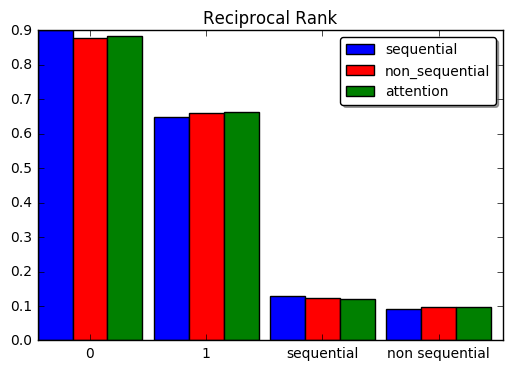

In [15]:
save_destination = "../plots/"

rr_seq = [0.60299999999999998, 0.90000000000000002, 0.64900000000000002, 0.129, 0.090999999999999998]
rr_nonseq = [0.60099999999999998, 0.879, 0.66100000000000003, 0.122, 0.096000000000000002]
rr_attention = [0.60399999999999998, 0.88500000000000001, 0.66300000000000003, 0.121, 0.096000000000000002]

fig = plt.figure()
begin = 0
end = 4
plt.title('Reciprocal Rank')
width = 0.3
h = plt.bar(np.arange(begin,end),rr_seq[begin+1:end+1],  width, color='b', label='sequential')
plt.bar(np.arange(begin,end)+width,rr_nonseq[begin+1:end+1],  width, color='r',label='non_sequential')
plt.bar(np.arange(begin,end)+2*width,rr_att[begin+1:end+1],  width, color='g',label='attention')
l = ['0', '1', 'sequential', 'non sequential']
xticks_pos = [1.5*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos,l)
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),
          ncol=1, fancybox=True, shadow=True, prop={'size': 10})
plt.savefig(save_destination+"rr.pdf", format='pdf', dpi=1200)
plt.show()



In [13]:
l = np.asarray([[0],[1],[0],[0],[0],[0],[0],[0],[0],[0]])
print l
print l.flatten()
print ordered_seq2set(l)
print ordered_seq2set(l.flatten())

[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[0 1 0 0 0 0 0 0 0 0]
[1]
[2]
